# Implémentez un modèle de scoring
lien github:https://github.com/Arsekoffi/projet_7

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
 
L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

####  Importation des librairies 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import gc
import time
from sklearn.impute import SimpleImputer
from contextlib import contextmanager

import sklearn.metrics

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, cross_validate, ShuffleSplit, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import joblib
import warnings
warnings.filterwarnings("ignore")

#### Chargement du jeu de données

In [2]:
application_train = pd.read_csv("application_train.csv")
application_test = pd.read_csv("application_test.csv")
bureau = pd.read_csv("bureau.csv")
bureau_balance = pd.read_csv("bureau_balance.csv")
credit_card_balance = pd.read_csv("credit_card_balance.csv")
installments_payments = pd.read_csv("installments_payments.csv")
previous_application = pd.read_csv("previous_application.csv")
POS_CASH_balance = pd.read_csv("POS_CASH_balance.csv")

#### Description du jeu de données 

In [3]:
#Fonction d'observation de chaque table. 
'''
Cette fonction affichera pour chaque dataset, les éléments suivants:
- La dimension de la table,
- Le nombre de données manquantes,
- Les nombre de doublons
- le type de variables, 
- les valeurs uniques de chaque variable
- La répartition des valeurs manquantes par variable

'''

def observation(df,name):
    #les dimmensions 
   
    print('les dimensions')
  
    dimensions= print("la dimension de la table" ,name, "est de", df.shape)
    print('---')
    print('les valeurs manquantes')
    
    #les données manquantes 
    NaN=df.isna().sum().sum()
    print("La somme des valeurs manquantes de la table",name, "est de",NaN)
    print('---')
    #les doublons 
    print('les doublons')

    doublons=df.duplicated().sum()
    print('Le nombre de doubons cette table est de ', doublons)
    print('---')
    #les types de colonnes
    print('les types de colonnes')

    print(df.dtypes.value_counts())
    print('---')
    #tableau qui résume le type de variables, les valeurs uniques et les valeurs manquantes 
    tableau=pd.DataFrame(df.dtypes, columns=['type de variable'])
    tableau['valeurs uniques']=df.nunique()
    #les valeurs manquantes 
    tableau['valeurs manquantes']= df.isna().sum()
    
    return tableau

In [4]:
observation(application_train,'application_train')

les dimensions
la dimension de la table application_train est de (307511, 122)
---
les valeurs manquantes
La somme des valeurs manquantes de la table application_train est de 9152465
---
les doublons
Le nombre de doubons cette table est de  0
---
les types de colonnes
float64    65
int64      41
object     16
Name: count, dtype: int64
---


,type de variable,valeurs uniques,valeurs manquantes
SK_ID_CURR,int64,307511,0
TARGET,int64,2,0
NAME_CONTRACT_TYPE,object,2,0
CODE_GENDER,object,3,0
FLAG_OWN_CAR,object,2,0
...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,float64,9,41519
AMT_REQ_CREDIT_BUREAU_WEEK,float64,9,41519
AMT_REQ_CREDIT_BUREAU_MON,float64,24,41519
AMT_REQ_CREDIT_BUREAU_QRT,float64,11,41519


In [5]:
observation(application_test,'application_test')

les dimensions
la dimension de la table application_test est de (48744, 121)
---
les valeurs manquantes
La somme des valeurs manquantes de la table application_test est de 1404419
---
les doublons
Le nombre de doubons cette table est de  0
---
les types de colonnes
float64    65
int64      40
object     16
Name: count, dtype: int64
---


,type de variable,valeurs uniques,valeurs manquantes
SK_ID_CURR,int64,48744,0
NAME_CONTRACT_TYPE,object,2,0
CODE_GENDER,object,2,0
FLAG_OWN_CAR,object,2,0
FLAG_OWN_REALTY,object,2,0
...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,float64,3,6049
AMT_REQ_CREDIT_BUREAU_WEEK,float64,3,6049
AMT_REQ_CREDIT_BUREAU_MON,float64,7,6049
AMT_REQ_CREDIT_BUREAU_QRT,float64,8,6049


## Choix d’un Kernel

#### Kernel pour l'analyse exploratoire:
"LightGBM with Simple Features"
https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction

In [6]:

application_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

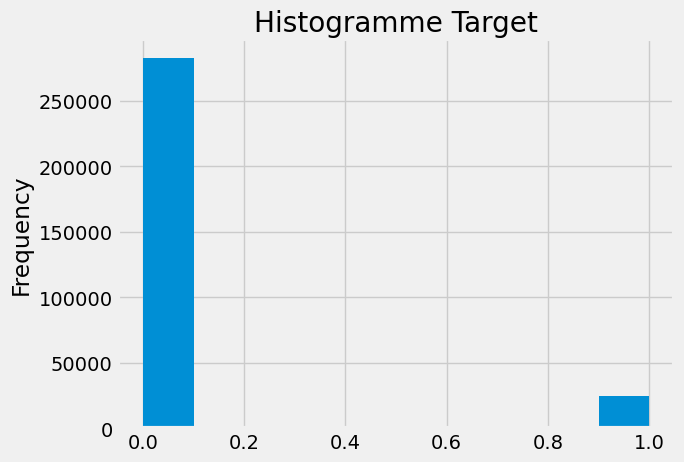

In [74]:
application_train['TARGET'].astype(int).plot.hist(title = 'Histogramme Target');

In [8]:
#outliers
(application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [9]:
application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

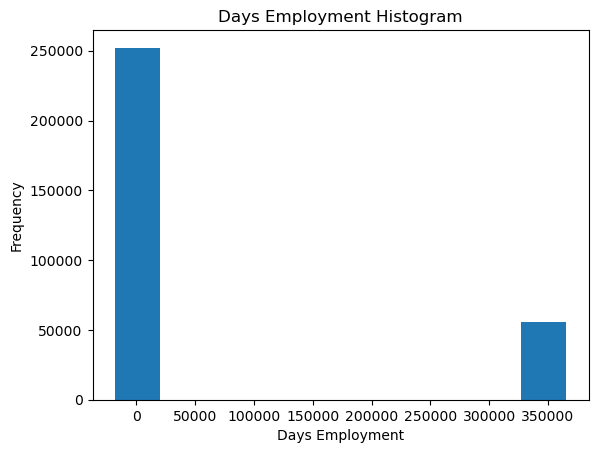

In [10]:
application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [11]:
anom = application_train[application_train['DAYS_EMPLOYED'] == 365243]
non_anom = application_train[application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


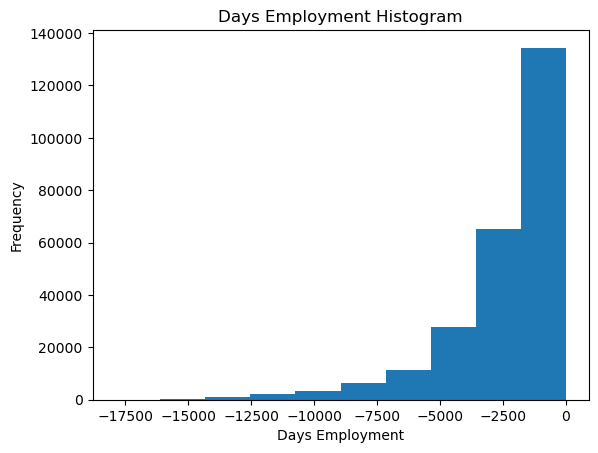

In [12]:
# Create an anomalous flag column
application_train['DAYS_EMPLOYED_ANOM'] = application_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [13]:
application_test['DAYS_EMPLOYED_ANOM'] = application_test["DAYS_EMPLOYED"] == 365243
application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (application_test["DAYS_EMPLOYED_ANOM"].sum(), len(application_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [14]:
#Correlations

# Find correlations with the target and sort
#correlations = application_train.corr()['TARGET'].sort_values()

# Display correlations
#print('Most Positive Correlations:\n', correlations.tail(15))
#print('\nMost Negative Correlations:\n', correlations.head(15))

In [15]:
# Find the correlation of the positive days since birth and target
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

-0.07823930830982709

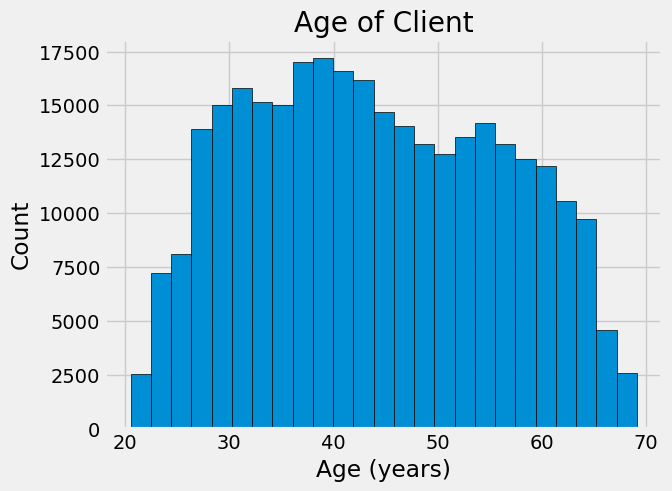

In [16]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(application_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

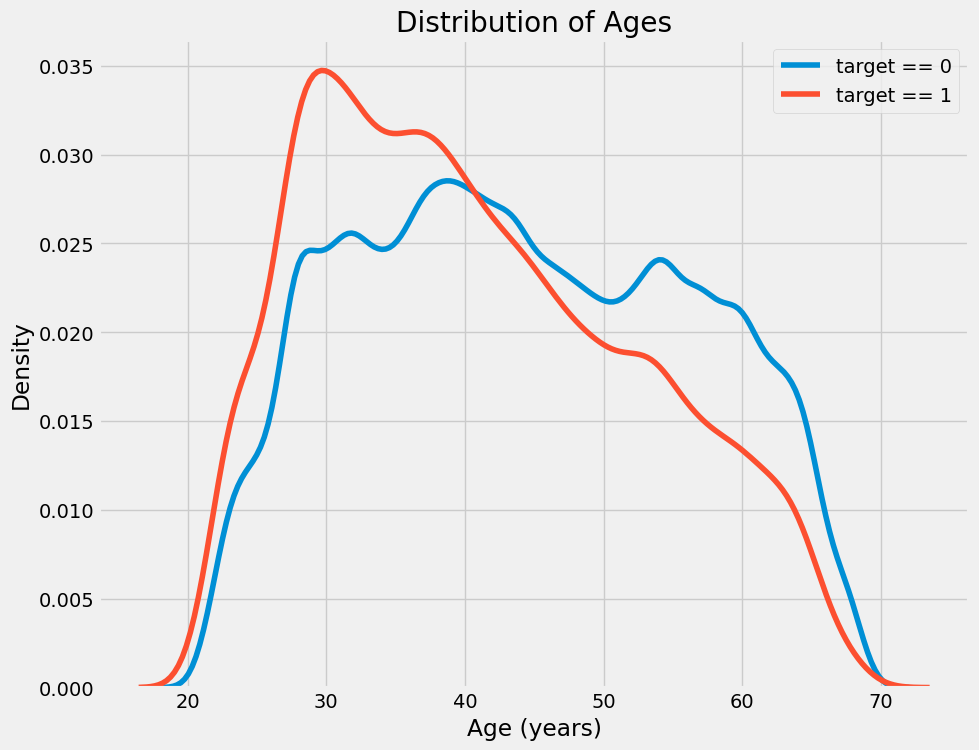

In [17]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')

plt.legend()
plt.show()


In [18]:
# Age information into a separate dataframe
age_data = application_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [19]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


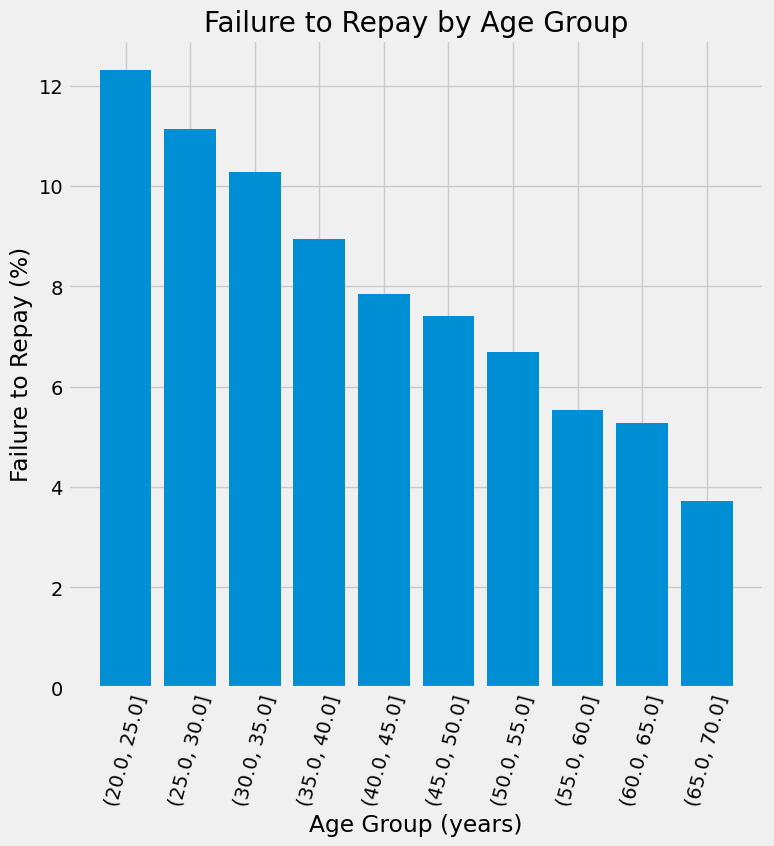

In [20]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

In [21]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


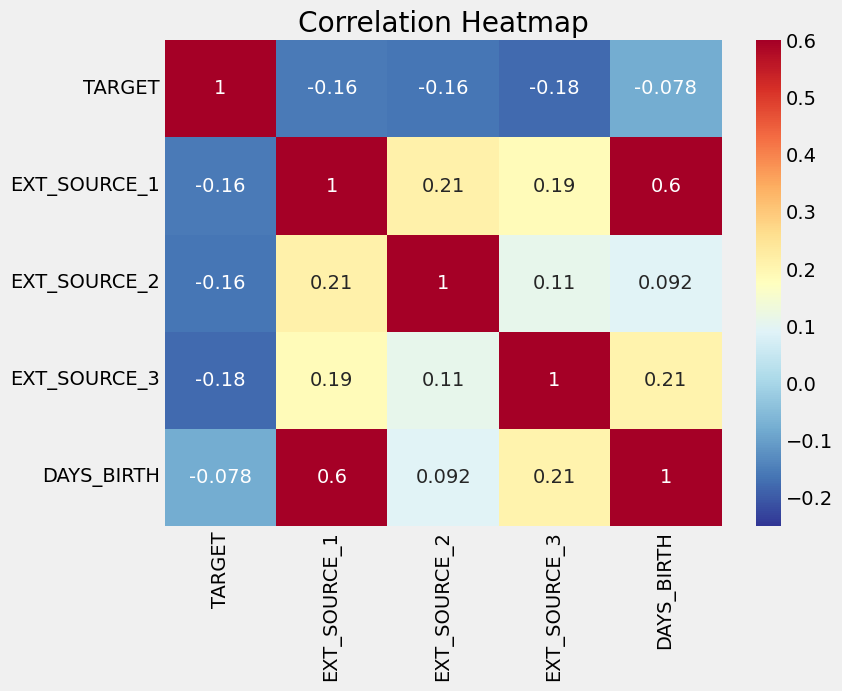

In [22]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');


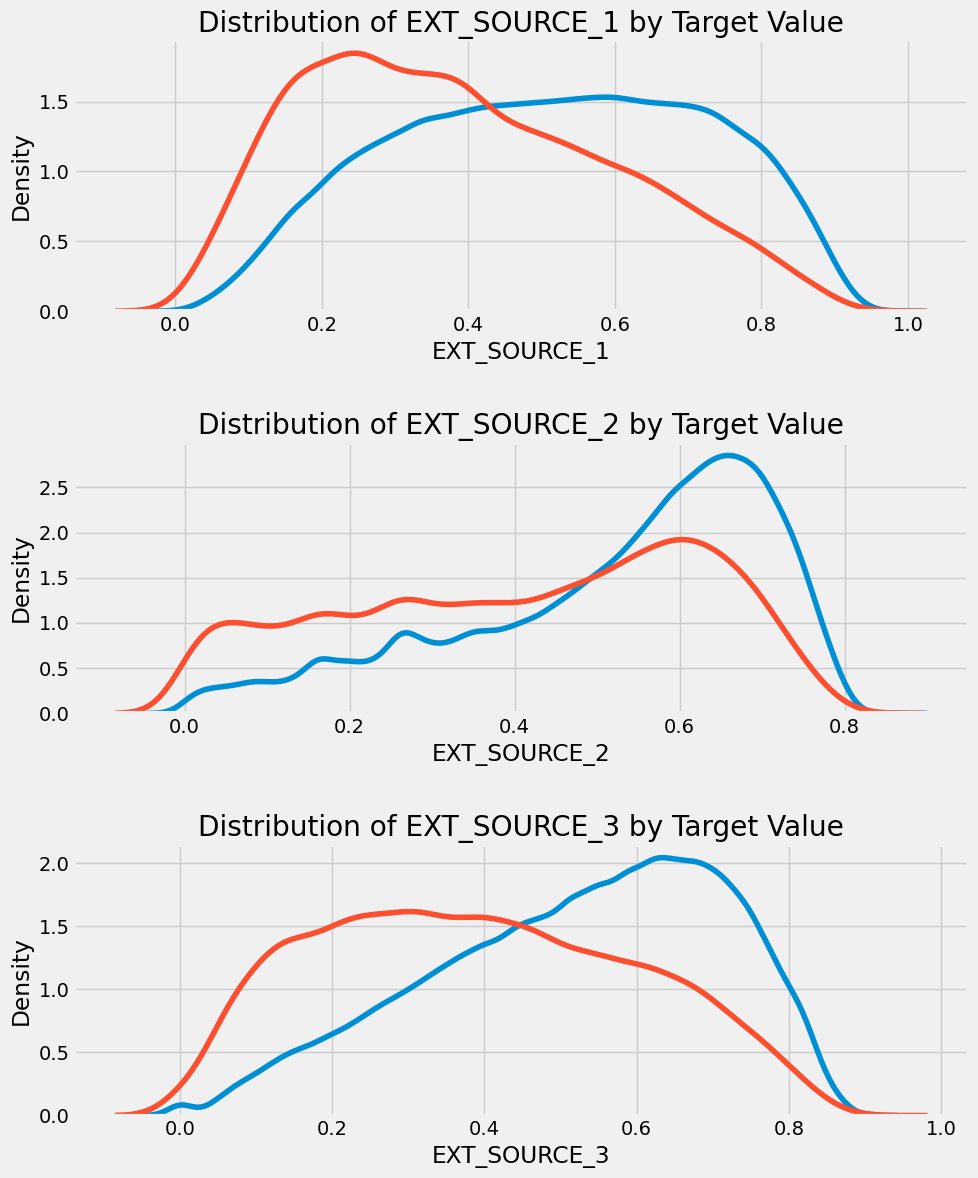

In [23]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

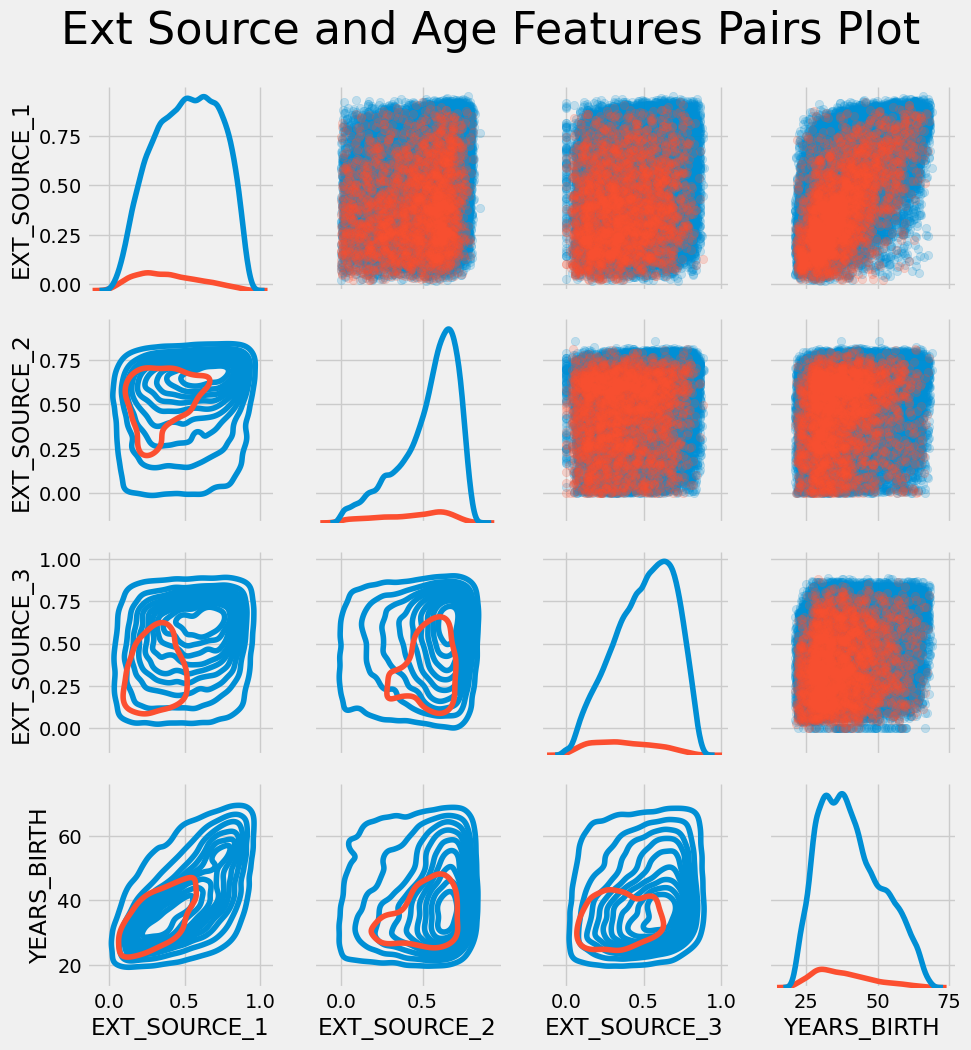

In [24]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data,  diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

#### Kernel pour le feature engineering :
"LightGBM with Simple Features"
https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [25]:
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    #df = df.append(test_df).reset_index()
    df=pd.concat([df,test_df]).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


In [26]:
def main(debug = False):
    num_rows = 10000 if debug else None
    
    df = application_train_test(num_rows)
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
    
       
    
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
  
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
    
    
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
    
    
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()
        
    
    df.to_csv("data.csv")
    
    return df

In [27]:
data=main(debug = False)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Previous applications df shape: (338857, 249)
Pos-cash balance df shape: (337252, 18)
Installments payments df shape: (339587, 26)
Credit card balance df shape: (103558, 141)


In [28]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


data=reduce_mem_usage(data)

Memory usage of dataframe is 1855.36 MB
Memory usage after optimization is: 646.54 MB
Decreased by 65.2%


In [29]:
df=data.copy()

In [30]:
import re

df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [31]:
 # Divide in training/validation and test data
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Starting Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

Starting Train shape: (307507, 798), test shape: (48744, 798)


In [32]:
#fonction de traitement des NaN
def replaceInf(data, replaceValue=np.nan):
    '''
    Replaces the np.inf values contained in 
    the dataframe <data> communicated as input and 
    replaces them with the value <replaceValue> 
    also communicated as input.
    Returns the modified dataframe <data>.
    '''
    nbInf = data.isin([np.inf, -np.inf]).sum().sum()
    print(f'{nbInf} infinite values detected.')
    if nbInf > 0:
        print(f'These values will be replaced by {replaceValue}')
        return data.replace([np.inf, -np.inf], replaceValue)
    else:
        return data
    
def replaceNan(data, strategy="median"):
    '''
    Replaces the np.nan values contained in 
    the dataframe <data> given as input and 
    replaces them via the SimpleImputer function 
    according to the <strategy> 
    also communicated as input.
    Returns the modified <data> dataframe.
    '''
    nbNaN = data.isnull().sum().sum()
    print(f'{nbNaN} NaN values detected.')
    if nbNaN > 0:
        print(f'Missing values will be replaced by the {strategy} of each column.')
        imp = SimpleImputer(missing_values=np.NaN,
                        strategy=strategy)
        return pd.DataFrame(imp.fit_transform(data),
                            columns=data.columns,
                            index=data.index)
    else:
        return data
    
    

train_df=replaceInf(train_df)
train_df=replaceNan(train_df)
test_df =replaceInf(test_df)
#test_df=replaceNan(test_df)

20 infinite values detected.
These values will be replaced by nan
63543549 NaN values detected.
Missing values will be replaced by the median of each column.
1 infinite values detected.
These values will be replaced by nan


In [33]:
test_df.index=test_df["SK_ID_CURR"]
test_df=test_df.drop(columns=['index',"TARGET",'SK_ID_CURR'],axis=1)
test_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1,0,0,0,135000.0,568800.0,20560.5,450000.0,0.018845,-19241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,0,0,0,0,99000.0,222768.0,17370.0,180000.0,0.035797,-18064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100013,0,1,0,0,202500.0,663264.0,69777.0,630000.0,0.019104,-20038,...,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0,96.0
100028,1,0,0,2,315000.0,1575000.0,49018.5,1575000.0,0.026398,-13976,...,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0,49.0
100038,0,1,1,1,180000.0,625500.0,32067.0,625500.0,0.010033,-13040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
test_df=replaceNan(test_df)

8507709 NaN values detected.
Missing values will be replaced by the median of each column.


In [35]:
sk=train_df["SK_ID_CURR"]

In [36]:
#exportation des tables 
train_df.to_csv('train_df.csv')
test_df.to_csv('test_df.csv')

In [37]:
#creation de dataset de taille réduite pour les chargements sur github
def sample (df, pourcentage=0.2):
    df_sample=df.iloc[0:10000,:]
    return df_sample
train_df_api=sample(train_df)
test_df_api=sample(test_df)
application_test_api=sample(application_test)
application_train_api=sample(application_train)

In [38]:
#exportation des données de tailles réduites 
train_df_api.to_csv('df_train_api.csv')
test_df_api.to_csv('df_test_api.csv')
application_test_api.to_csv('test_api.csv')
application_train_api.to_csv('train_api.csv')

## Développement et simulation de modèles

In [39]:
#separation du en train/test 
def separation(df):
    sk=df["SK_ID_CURR"]
    df.index=sk
    X = df.drop(['index','SK_ID_CURR',
                 'TARGET'], axis=1)
    y = df['TARGET']
    sss = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test,=separation(train_df)

In [40]:
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(y_test, 'y_test.pkl')

['y_test.pkl']

### Fonction de coût métier – Création d’un score métier

La problématique « métier » est de prendre en compte qu’un faux positifs (bon client considéré comme mauvais = crédit non accordé à tort, donc manque à gagner de la marge pour la banque) n’a pas le même coût qu’un faux négatif (mauvais client à qui on accorde un prêt, donc perte sur le capital non remboursé). Un faux négatif est environ 10 fois plus coûteux qu’un faux positif. Les mesures techniques tels que le f1 score ne le prennent pas en compte


Nous allons créer un score “métier” via “make_scorer” qui calcule le coût des erreurs de prédiction (donc les FN et FP). Les modèles et leur hyperparamètres seront optimisés via un GridSearchCV ou équivalent sur ce score.

Le score “métier” consiste à calculer une fonction de coût métier de type 10*FN + FP  (où FN = nombre de FN dans la matrice de confusion pour un seuil donné, FP = nombre de FP) et de trouver son minimum pour un seuil donné

In [41]:
#Création score métier 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import fbeta_score, make_scorer, auc,roc_auc_score

def custom_metric(y_true, y_pred):
    """Fonction qui extraie de la matrice de confusion les
    valeurs des 4 mesures et retourne un calcul sur base
    d'une pondération de FP et FN"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel().tolist()
    score=(10*fn + fp)/len(y_true)
    return score
score_metier=make_scorer(custom_metric, greater_is_better=False)

scoring = {"AUC": "roc_auc", "score_metier": score_metier}


In [42]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
def plot_sklearn_roc_curve(y_real, y_pred):
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')

le jeu de données est **déséquilibré** (92% de bon clients). On doit effectuer un **traitement de rééquilibrage**. Nous choisisons la methode par **oversampling**, via la librairie Smote, pour générer de nouveaux enregistrements de classe 1. Pour éviter le data leakage lors de la cross validation, l’oversampling se fera pour chaque jeu de données entraîné via la **pipeline imblearn**.

#### Modélisation
Simulation complète des algorithmes suivants:
- DummyClassifier
- LogisiticRegression
- DecisionTree Classifier
- LGBMClassifier
- CatBoostClassifier

In [43]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import joblib

def find_best_model_using_gridsearchcv(X_train,y_train):
    algos = { 
    #----------- 'Dummy'--------------- 
        'Dummy':{
            'model': Pipeline([
         ('over', SMOTE(random_state=42)),
         ('scaler',StandardScaler()),
         ('dummy',DummyClassifier())
    ]),
            'params': {
                'dummy__strategy': ['most_frequent',
                                    'stratified'] }
            },
        
    #-------------"LogisiticRegression"-----------
        
        'LogisiticRegression':{
            'model': Pipeline([
         ('over', SMOTE(random_state=42)),
         ('scaler',StandardScaler()),
         ('Logreg',LogisticRegression(solver='lbfgs',
             class_weight='balanced', 
                                      max_iter=10000
         ))
    ]),
            'params': {
                'Logreg__penalty': ['l2'],
                'Logreg__C': [100,1000]
            }
            },
     #------------"DecisionTree Classifier"---------- 
        
        
        'DecisionTree Classifier':{
            'model': Pipeline([
         ('over', SMOTE(random_state=42)),
         ('scaler',StandardScaler()),
         ('DecisionTree',DecisionTreeClassifier())
    ]),
            'params': {
                'DecisionTree__criterion': ["gini", "entropy"],
                'DecisionTree__min_samples_leaf': list(range(5,7,1)),
                "DecisionTree__max_depth": list(range(2,4,1))
            }
            },
        
     #------------"LGBMClassifier"---------- 
        "LGBMClassifier": {
            'model': Pipeline([
         ('over', SMOTE(random_state=42)),
         ('scaler',StandardScaler()),
         ('LGBMC',LGBMClassifier())
    ]),
            'params': {
            'LGBMC__subsample': [0.5, 0.75],
            'LGBMC__reg_lambda': [ 1, 2],
            'LGBMC__colsample_bytree': [ 0.97, 0.99]
            
            }
        },
        
         #------------'CatBoostClassifier'----------  
        'CatBoostClassifier': {
            'model': Pipeline([
         ('over', SMOTE(random_state=42)),
         ('scaler',StandardScaler()),
         ('CatBoost',CatBoostClassifier(logging_level='Silent'))]),
            'params': {
            'CatBoost__max_depth': [3,4,6],
            'CatBoost__n_estimators':[100, 200, 300],
           }
            }

    }
    
    scores = []
    best_score = 1
    cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state=45)
    for algo_name, config in algos.items():
        
        gs =  GridSearchCV(config['model'], 
                           config['params'],
                           cv=cv,
                           scoring=scoring,
                           refit="AUC",
                           verbose=1,
                           return_train_score=True)
        gs.fit(X_train, y_train)
        gs.best_estimator_[1]
        
        # Predict the classes on the test data
        y_pred= gs.best_estimator_.predict(X_train)
        # Predict the classes on the test data, 
        #and return the probabilities for each class
        y_proba=gs.best_estimator_.predict_proba(X_train)
        y_test_proba=gs.best_estimator_.predict_proba(X_test)
        score_metier=custom_metric(y_train, y_pred)
        gs.score(X_test, y_test)
        print('--------------',algo_name,'-------------')
        print('Best params: ',algo_name,gs.best_params_)
        print('Score_metier ',score_metier)
        print('score_AUC_train ',roc_auc_score(y_train, y_proba[:, 1]))
        print('score_AUC_test ',roc_auc_score(y_test, y_test_proba[:, 1]))
        
        #saving the best model 
        if score_metier<best_score:
            best_score=score_metier
            best_params=gs.best_params_
            model_name=algo_name
            best_model=gs.best_estimator_
            
            joblib.dump(best_model, 'best_model.joblib')
            joblib.dump(best_model, 'best_model.sav')
        
        #Time
        mean_fit_time= gs.cv_results_['mean_fit_time']
        mean_score_time= gs.cv_results_['mean_score_time']
        n_splits  = gs.n_splits_ #number of splits of training data
        n_iter = pd.DataFrame(gs.cv_results_).shape[0] #Iterations par split
        
#------------Matrice de confusion--------------      
        plt.figure(figsize =(4, 4))
        cm = confusion_matrix(y_train, y_pred)
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(
            group_names, group_counts, group_percentages)]
        labels= np.asarray(labels).reshape(2, 2)
        categories = ['0', '1']
        sns.heatmap(cm, annot=labels,  fmt='',
                    cmap='Blues')
        plt.ylabel('classe réelle')
        plt.xlabel('classe estimée')
        plt.title('Matrice de confusion '+algo_name,
                fontsize = 10,)
        plt.show()
        print(classification_report(y_train, y_pred))
        
#-------------Roc_curve---------------
        plt.figure(figsize =(4, 4))
        plot_sklearn_roc_curve(y_train, y_proba[:, 1])
        plt.title('Roc_curve '+algo_name,
                fontsize = 10)
        plt.show()
#------------métriques-------------
        scores.append({
            'Model':algo_name,
            'AUC_train' : roc_auc_score(y_train, y_proba[:, 1]),
            'AUC_test': roc_auc_score(y_test, y_test_proba[:, 1]),
            'Score_metier':custom_metric(y_train, y_pred),
            'Time_min':((np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter)/60)
            })
        
        
    results= pd.DataFrame(scores,columns=['Model','AUC_train','AUC_test','Score_metier','Time_min'])
          
    plt.figure(figsize=(10,6))
    plt.title('Comparaison des scores metiers ')
    sns.barplot(y = results['Model'],x= results['Score_metier'])
    plt.show()
        
    plt.figure(figsize=(10,6))
    plt.title('Comparaison des AUC')
    sns.barplot(y = results['Model'],x= results['AUC_train'])
    plt.show()
    
    plt.figure(figsize=(10,6))
    plt.title("Comparaison des temps d'entrainement")
    sns.barplot(y = results['Model'],x= results['Time_min'])
    plt.show()
    
    results.head()
        
       
    return {"model_name":model_name,'best_score':best_score,'best_params':best_params}

Fitting 5 folds for each of 2 candidates, totalling 10 fits
-------------- Dummy -------------
Best params:  Dummy {'dummy__strategy': 'most_frequent'}
Score_metier  0.8072973829906588
score_AUC_train  0.5
score_AUC_test  0.5


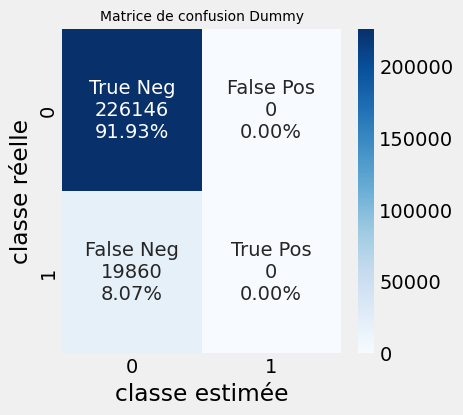

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    226146
         1.0       0.00      0.00      0.00     19860

    accuracy                           0.92    246006
   macro avg       0.46      0.50      0.48    246006
weighted avg       0.85      0.92      0.88    246006



<Figure size 400x400 with 0 Axes>

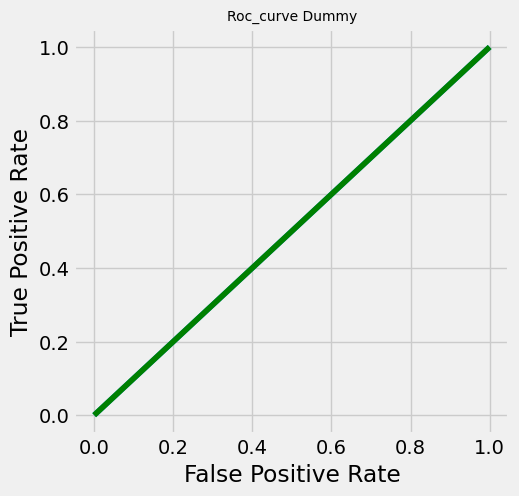

Fitting 5 folds for each of 2 candidates, totalling 10 fits
-------------- LogisiticRegression -------------
Best params:  LogisiticRegression {'Logreg__C': 100, 'Logreg__penalty': 'l2'}
Score_metier  0.4950692259538385
score_AUC_train  0.7815978887668652
score_AUC_test  0.7700454867958546


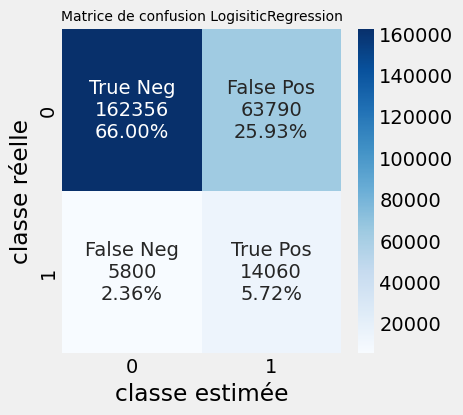

              precision    recall  f1-score   support

         0.0       0.97      0.72      0.82    226146
         1.0       0.18      0.71      0.29     19860

    accuracy                           0.72    246006
   macro avg       0.57      0.71      0.56    246006
weighted avg       0.90      0.72      0.78    246006



<Figure size 400x400 with 0 Axes>

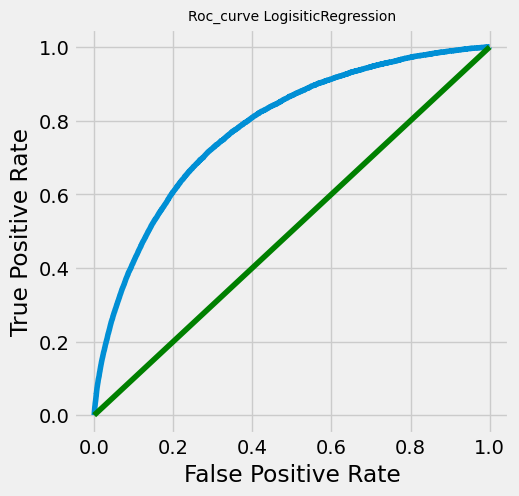

Fitting 5 folds for each of 8 candidates, totalling 40 fits
-------------- DecisionTree Classifier -------------
Best params:  DecisionTree Classifier {'DecisionTree__criterion': 'entropy', 'DecisionTree__max_depth': 3, 'DecisionTree__min_samples_leaf': 5}
Score_metier  0.6884059738380365
score_AUC_train  0.5999673255357345
score_AUC_test  0.5929330130497464


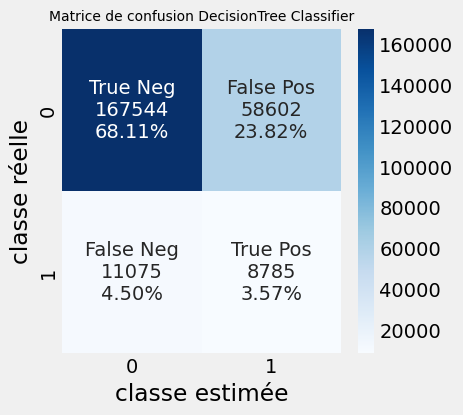

              precision    recall  f1-score   support

         0.0       0.94      0.74      0.83    226146
         1.0       0.13      0.44      0.20     19860

    accuracy                           0.72    246006
   macro avg       0.53      0.59      0.51    246006
weighted avg       0.87      0.72      0.78    246006



<Figure size 400x400 with 0 Axes>

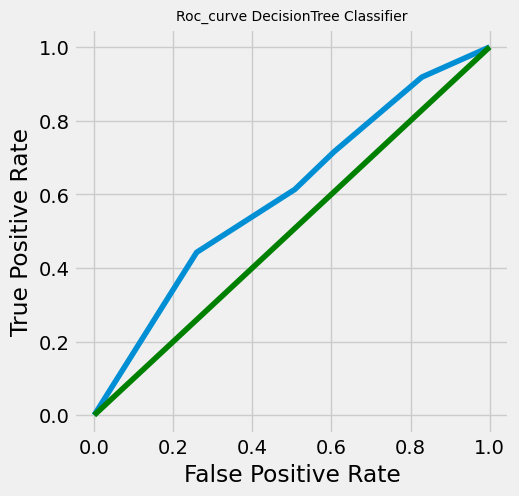

Fitting 5 folds for each of 8 candidates, totalling 40 fits
-------------- LGBMClassifier -------------
Best params:  LGBMClassifier {'LGBMC__colsample_bytree': 0.97, 'LGBMC__reg_lambda': 2, 'LGBMC__subsample': 0.5}
Score_metier  0.7821638496622033
score_AUC_train  0.8033877805984564
score_AUC_test  0.7745514911156075


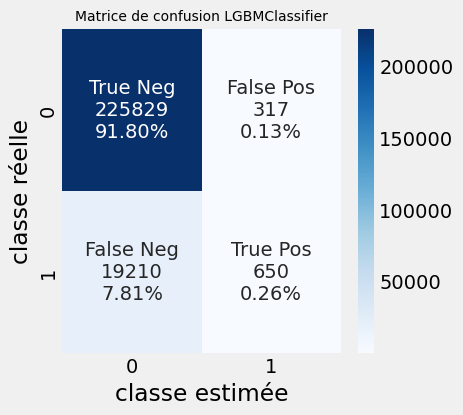

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    226146
         1.0       0.67      0.03      0.06     19860

    accuracy                           0.92    246006
   macro avg       0.80      0.52      0.51    246006
weighted avg       0.90      0.92      0.89    246006



<Figure size 400x400 with 0 Axes>

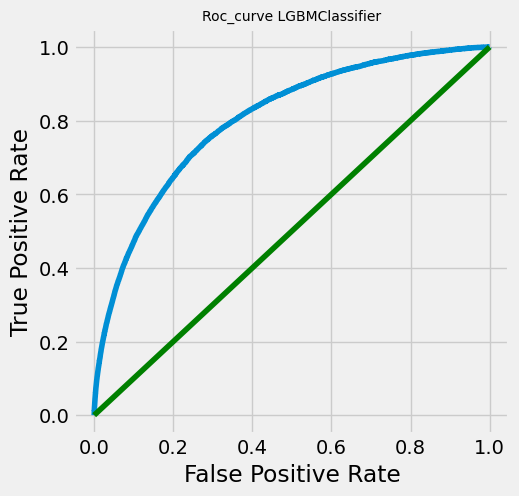

Fitting 5 folds for each of 9 candidates, totalling 45 fits
-------------- CatBoostClassifier -------------
Best params:  CatBoostClassifier {'CatBoost__max_depth': 3, 'CatBoost__n_estimators': 300}
Score_metier  0.7488597839077096
score_AUC_train  0.810142354141741
score_AUC_test  0.7775554571828753


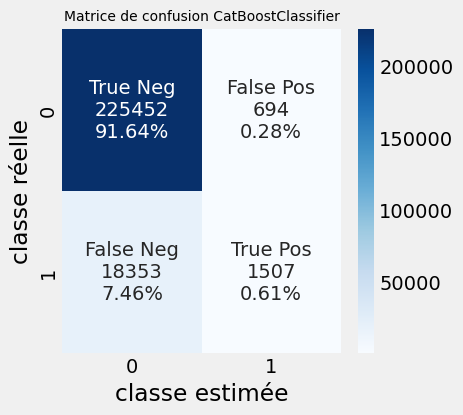

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    226146
         1.0       0.68      0.08      0.14     19860

    accuracy                           0.92    246006
   macro avg       0.80      0.54      0.55    246006
weighted avg       0.91      0.92      0.89    246006



<Figure size 400x400 with 0 Axes>

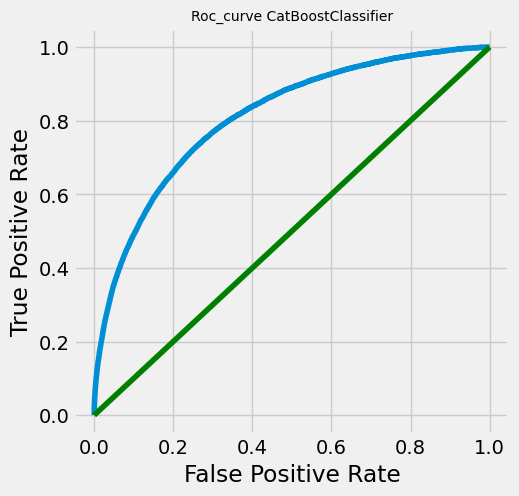

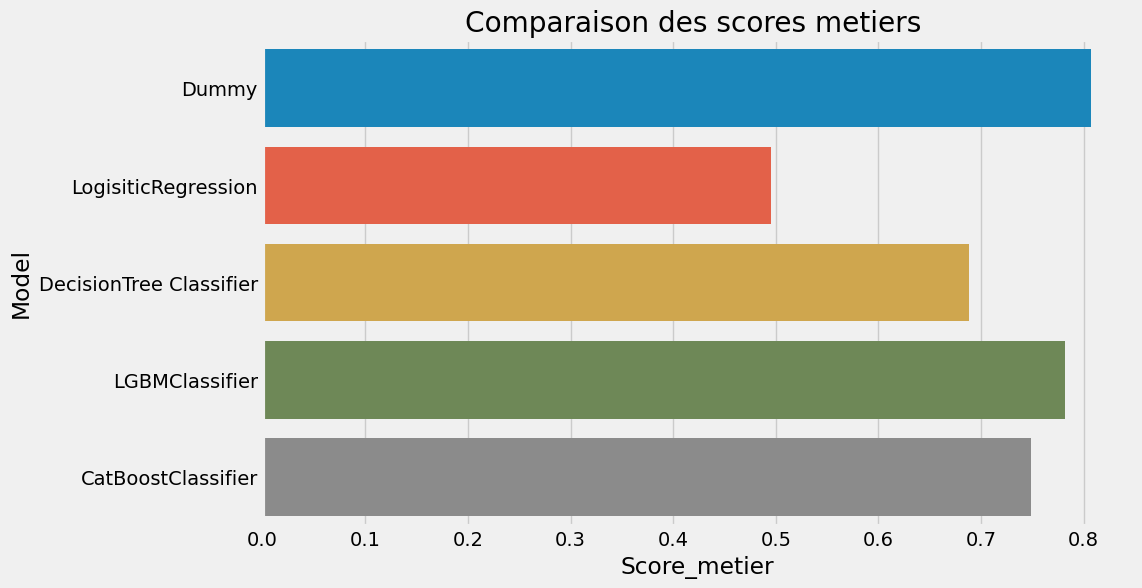

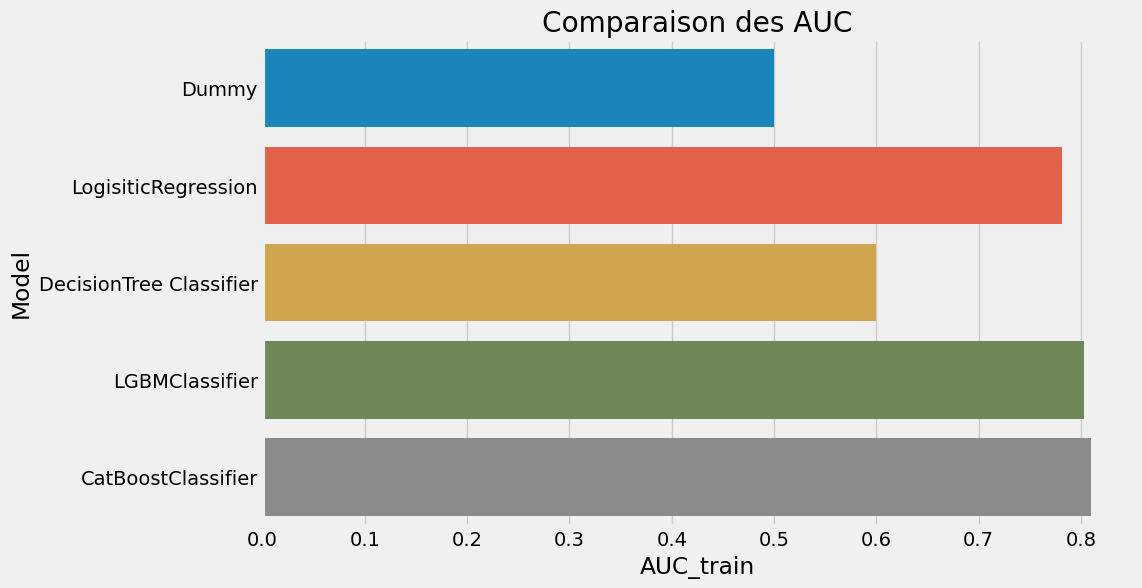

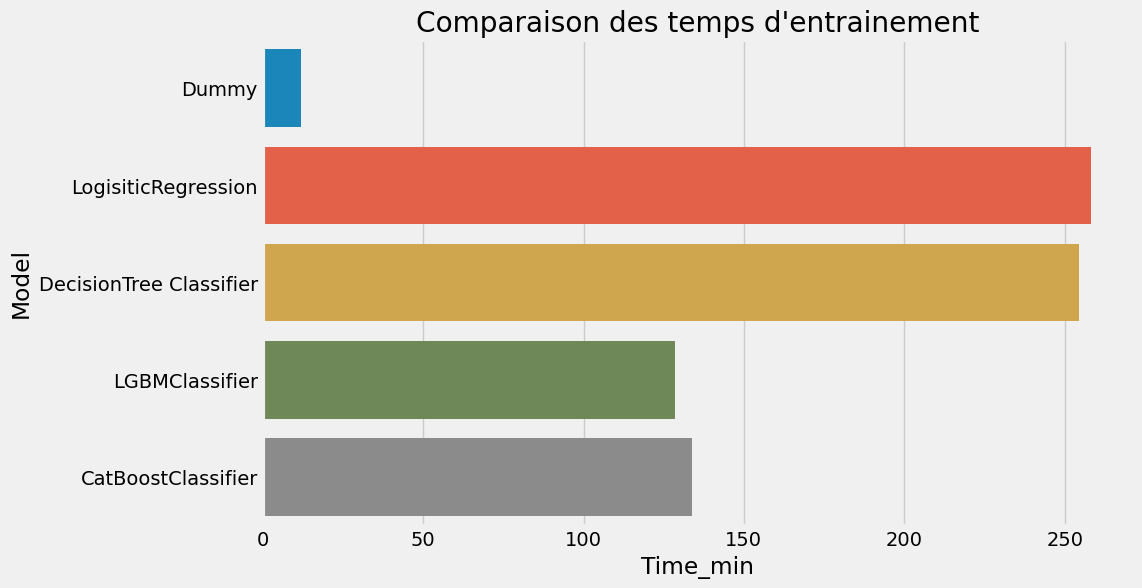

{'model_name': 'LogisiticRegression',
 'best_score': 0.4950692259538385,
 'best_params': {'Logreg__C': 100, 'Logreg__penalty': 'l2'}}

In [44]:
find_best_model_using_gridsearchcv(X_train,y_train)

In [45]:
loaded_model = joblib.load('best_model.joblib')
loaded_model

Pipeline(steps=[('over', SMOTE(random_state=42)), ('scaler', StandardScaler()),
                ('Logreg',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=10000))])

In [46]:
#search best thersholds

from sklearn.metrics import f1_score
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
# predict probabilities
y_pred= loaded_model.predict(X_train)
y_proba=loaded_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = y_proba[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold

scores = [roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
thresh=thresholds[ix]
print('Threshold=%.3f ' %thresholds[ix], 'score=%.5f' %scores[ix])
joblib.dump(thresh, 'thresh.joblib')


Threshold=0.494  score=0.71341


['thresh.joblib']

#### Analyse de la « feature importance » globale et locale

In [47]:

import shap
# load JS visualization code to notebook
shap.initjs()

Linear explainer: 61502it [00:10, 125.85it/s]                                                                          


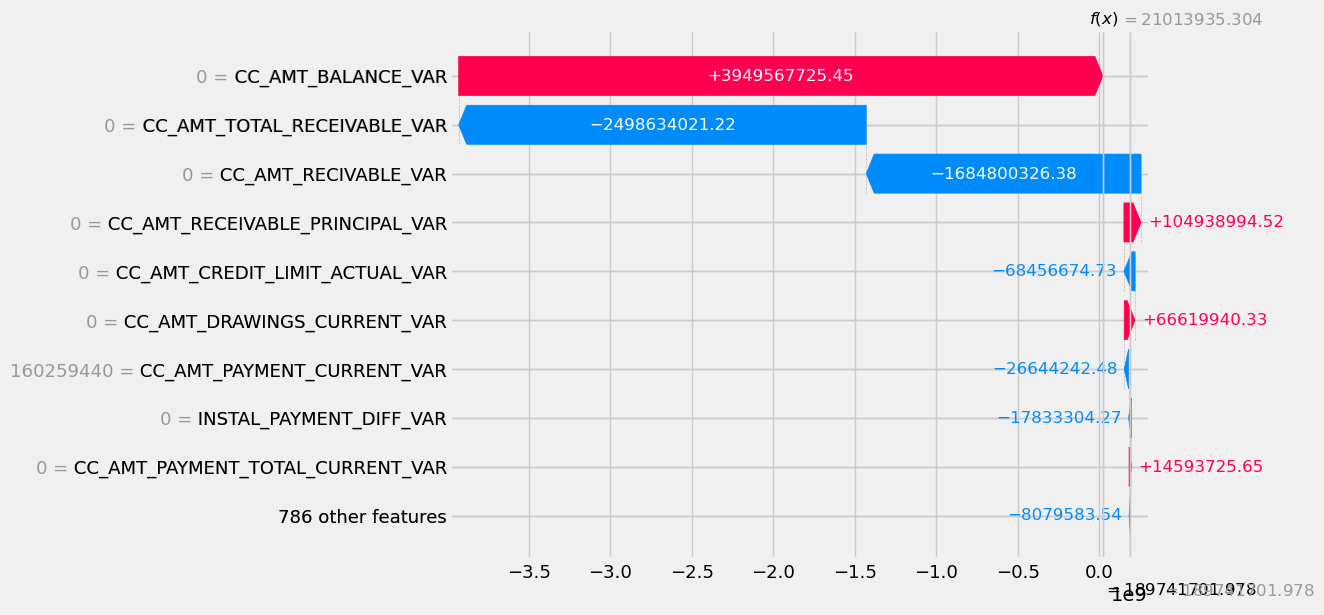

In [59]:
from shap import LinearExplainer, KernelExplainer, Explanation
from shap.maskers import Independent
background = Independent(X_test, max_samples=100)
explainer = LinearExplainer(loaded_model['Logreg'],background)
shap_values = explainer(X_test)
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

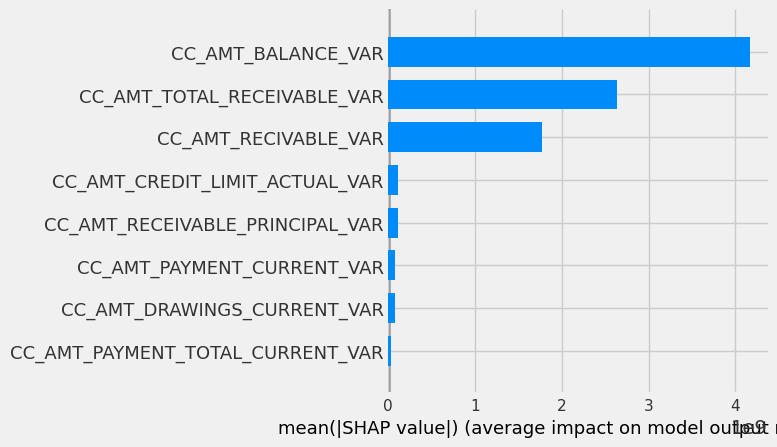

In [60]:
shap.summary_plot(shap_values, X_test, plot_type='bar',max_display=8)

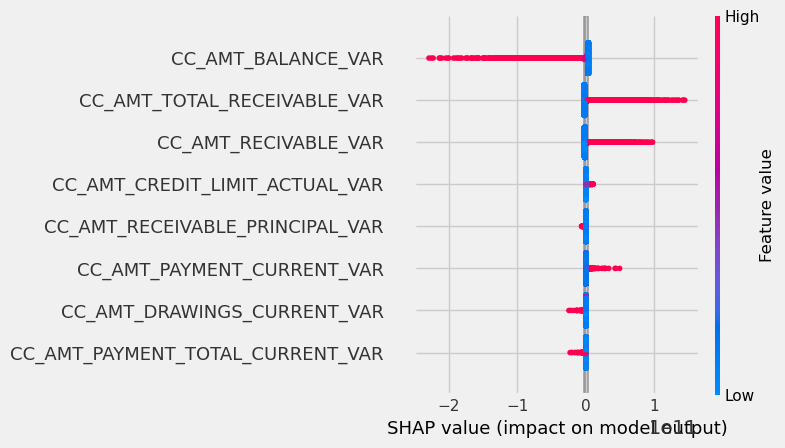

In [61]:
shap.summary_plot(shap_values, X_test,max_display=8)

In [77]:
#feature importance locale
i = 1
shap.force_plot( explainer.expected_value, shap_values.values[i,:], features=X_test.iloc[i])

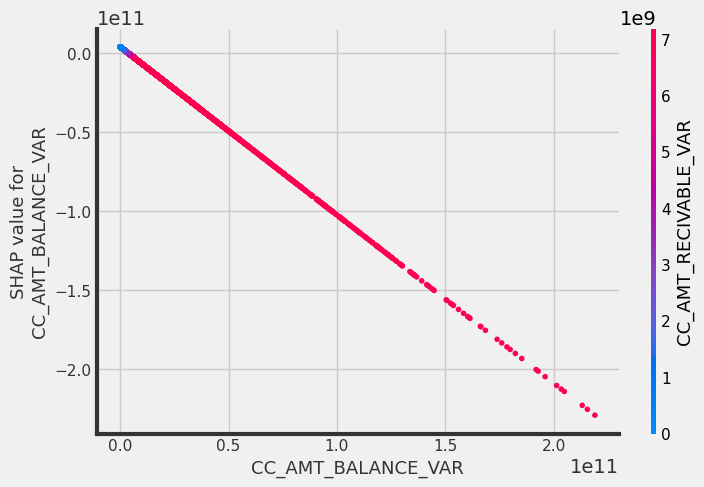

In [62]:
shap.dependence_plot('CC_AMT_BALANCE_VAR', shap_values.values, X_test)

In [64]:
#description des variables 
des=pd.read_csv('HomeCredit_columns_description.csv',encoding='latin1')
des.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [72]:
liste=[
       'AMT_BALANCE',
       'AMT_TOTAL_RECEIVABLE',
       'AMT_CREDIT_LIMIT_ACTUAL',
       'AMT_RECEIVABLE_PRINCIPAL',
       'AMT_PAYMENT_CURRENT',
       'AMT_DRAWINGS_CURRENT',
       'AMT_PAYMENT_TOTAL_CURRENT'
      ]

In [73]:
result=des[des['Row'].isin(liste)]
result.head()
pd.set_option('display.max_colwidth',None)
result[['Row','Description']]

,Row,Description
153,AMT_BALANCE,Balance during the month of previous credit
154,AMT_CREDIT_LIMIT_ACTUAL,Credit card limit during the month of the previous credit
156,AMT_DRAWINGS_CURRENT,Amount drawing during the month of the previous credit
160,AMT_PAYMENT_CURRENT,How much did the client pay during the month on the previous credit
161,AMT_PAYMENT_TOTAL_CURRENT,How much did the client pay during the month in total on the previous credit
162,AMT_RECEIVABLE_PRINCIPAL,Amount receivable for principal on the previous credit
164,AMT_TOTAL_RECEIVABLE,Total amount receivable on the previous credit
